In [1456]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [1457]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-dark-palette')

In [1458]:
train_raw_df = pd.read_csv("../../data/input/hugging_face/train_raw.csv")
train_raw_df = train_raw_df.sample(frac=1, random_state=322)

test_df = pd.read_csv("../../data/input/hugging_face/test.csv")


In [1459]:
print(train_raw_df.shape)

(113, 2)


In [1460]:
batch_raw = pd.concat([train_raw_df,test_df],
axis=0,
ignore_index=True)
batch_raw.to_csv("../../data/input/hugging_face/data_val/raw_train_test.csv")



In [1461]:
print(batch_raw.shape)

(188, 2)


In [1462]:
# For DistilBERT:
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
#model_class, tokenizer_class, pretrained_weights= (ppb.RobertaModel,ppb.RobertaTokenizer,"roberta-base")
## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1463]:
tokenized_raw = batch_raw["Question"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_raw.to_csv("./test.csv")

In [1464]:
max_len = 0
for i in tokenized_raw.values:
    if len(i) > max_len:
        max_len = len(i)

padded_raw = np.array([i + [0]*(max_len-len(i)) for i in tokenized_raw.values])
max_len


28

In [1465]:
np.array(padded_raw).shape


(188, 28)

In [1466]:
attention_mask_raw = np.where(padded_raw != 0, 1, 0)
attention_mask_raw.shape

(188, 28)

In [1467]:
input_ids_raw = torch.tensor(padded_raw)  
attention_mask_raw = torch.tensor(attention_mask_raw)

with torch.no_grad():
    last_hidden_states_raw = model(input_ids_raw, attention_mask=attention_mask_raw)

In [1468]:
features_raw = last_hidden_states_raw[0][:,0,:].numpy()

In [1469]:
labels_raw = batch_raw["op_id"]

In [1470]:
labels_raw.shape

(188,)

In [1471]:
train_raw_shape = train_raw_df.shape
train_raw_features = features_raw[:train_raw_shape[0]]
test_raw_features = features_raw[train_raw_shape[0]:]
train_raw_labels = labels_raw[:train_raw_shape[0]]
test_raw_labels =labels_raw[train_raw_shape[0]:] 

In [1472]:
print(train_raw_features.shape)
print(test_raw_features.shape)
print(train_raw_labels.shape)
print(test_raw_labels.shape)

(113, 768)
(75, 768)
(113,)
(75,)


In [1473]:
train_raw_features.shape

(113, 768)

In [1474]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

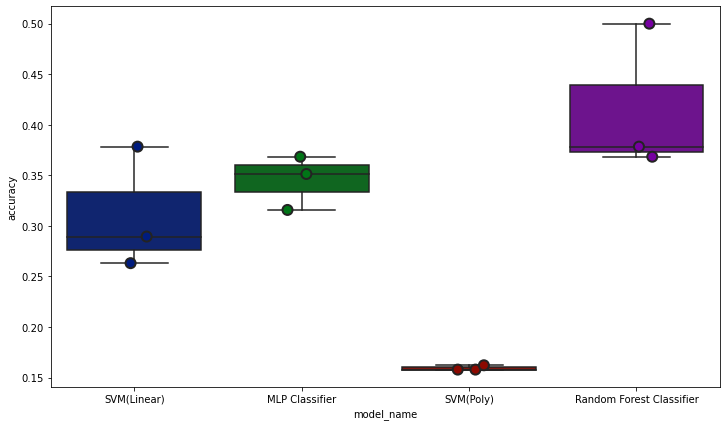

In [1475]:

model_names = [
    "SVM(Linear)",
    "MLP Classifier",
    "SVM(Poly)",
    "Random Forest Classifier"
]
models = [
    SVC(kernel='linear',
        random_state=494,
    ),
    MLPClassifier( solver="adam", random_state=2343, hidden_layer_sizes=(),activation="identity"),
    SVC(kernel='poly',
        random_state=494,
    ),
    RandomForestClassifier(max_depth=10)
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for i,model in enumerate(models):
    model_name = model_names[i]
    accuracies = cross_val_score(model,train_raw_features, train_raw_labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=[12,7])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig("../../figures/huggingface/test.png",bbox_inches='tight')
plt.show()

In [1476]:
cv_df.groupby('model_name').accuracy.mean()

model_name
MLP Classifier              0.345187
Random Forest Classifier    0.415600
SVM(Linear)                 0.310337
SVM(Poly)                   0.159317
Name: accuracy, dtype: float64

[ 8  2 18  8  8  8  8  0  5  8  8  8  8  8  8  8  8 53 53  8  8  8 19  8
  8 46 46  8 39 39  8 14  8  8 18 15  8  5  5  5  5  5  5 33 18  5 28  5
  8 28  8 28  2  2 50 50  8  2 27 18  2  8  5  8  8  5  5 18 18 18  8 50
 50 13 13]


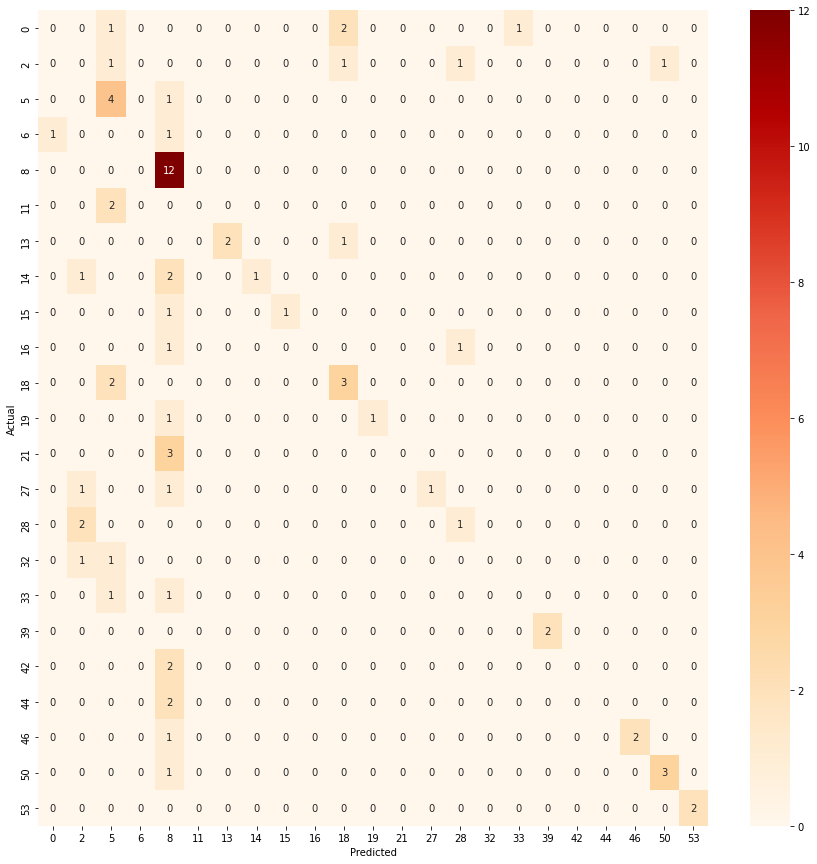

In [1477]:
model = MLPClassifier( hidden_layer_sizes=(),activation="identity")

model.fit(train_raw_features, train_raw_labels)
y_pred = model.predict(test_raw_features)
print(y_pred)


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_raw_labels, y_pred)

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(test_raw_labels.values))), 
            yticklabels=sorted(list(set(test_raw_labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [1478]:
from sklearn import metrics

unique_keys = sorted(list(set(test_raw_labels.values)))
print('accuracy %s' %metrics.accuracy_score(y_pred,test_raw_labels))

accuracy 0.4666666666666667
